In [28]:
import os
import cv2
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization, MaxPooling2D
from keras.models import Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# set data directory
train_dir='train'
test_dir='test'

In [4]:
# Using image data generator to load images from directory
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)


train_data = train_generator.flow_from_directory(
    directory=train_dir,
    subset='training',
    target_size=(50,50),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=64
)

Found 24406 images belonging to 7 classes.


In [5]:
val_data = train_generator.flow_from_directory(
    directory=train_dir,
    subset='validation',
    target_size=(50,50),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=64
)

Found 4303 images belonging to 7 classes.


In [6]:
test_generator = ImageDataGenerator(rescale=1./255)

test_data = test_generator.flow_from_directory(
    directory=test_dir,
    target_size=(50,50),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=64,
    shuffle=False
)

Found 7178 images belonging to 7 classes.


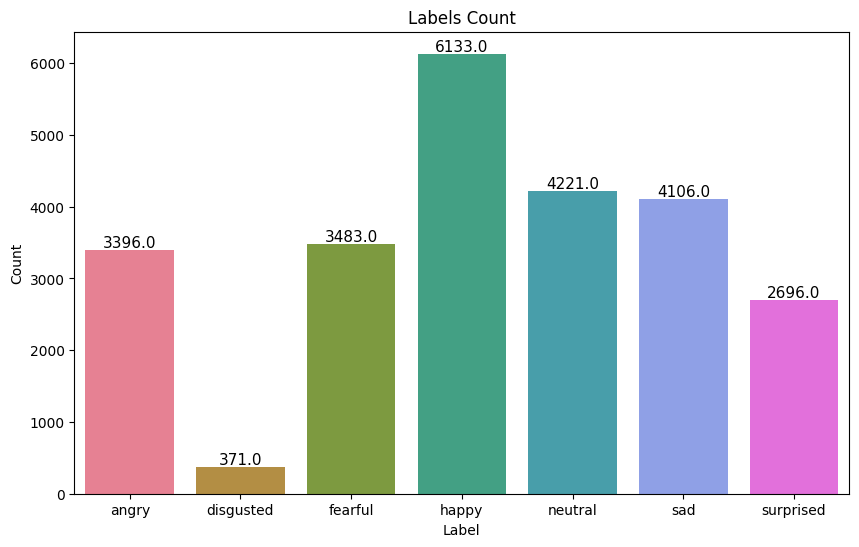

In [7]:
# Get the label counts
label_counts = train_data.classes

# Convert label counts array to DataFrame
label_counts_df = pd.DataFrame(label_counts, columns=['label'])

# Map label indices to label names
label_names = {v: k for k, v in train_data.class_indices.items()}
label_counts_df['label'] = label_counts_df['label'].map(label_names)

# Plot the countplot vertically
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=label_counts_df, orient='v', palette='husl')
plt.title('Labels Count')
plt.xlabel('Label')
plt.ylabel('Count')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points', rotation=0)

plt.show()

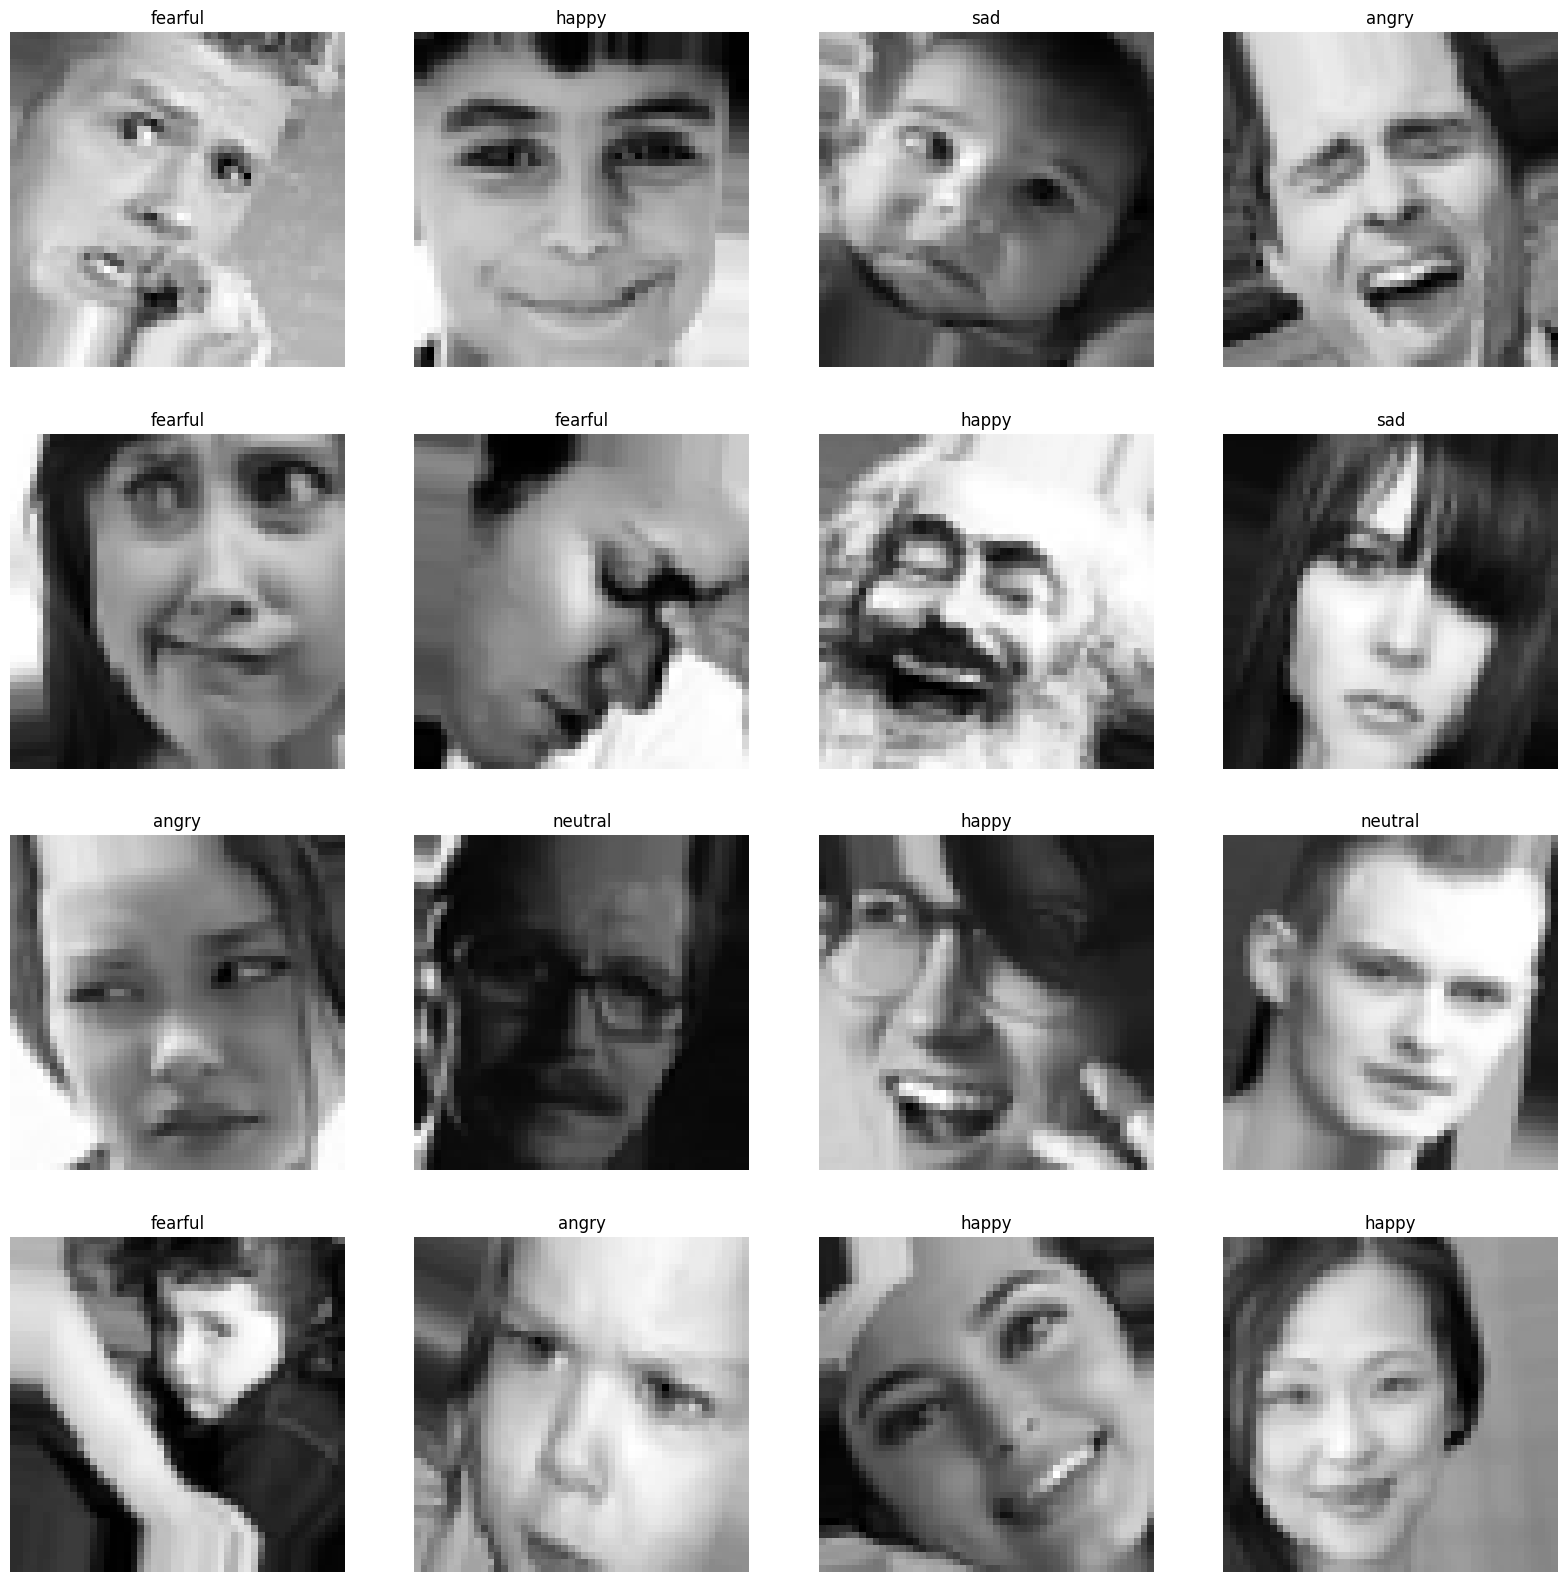

In [8]:
# To display a grid of images
plt.figure(figsize=(20, 20))

# Loop to print each image
for index, (images, labels) in enumerate(train_data):
    if index == 16:
        break  # Break after displaying 16 batches of images
    for i in range(len(images)):
        # Calculate subplot index directly based on current and total images
        subplot_index = (index * len(images) + i) % 16 + 1 
        plt.subplot(4, 4, subplot_index)
        img = images[i]
        label_index = int(labels[i])  # Get the index of the label
        label_name = list(train_data.class_indices.keys())[label_index]  # Get the corresponding label name
        plt.imshow(img.reshape((50, 50)), cmap='gray')  # Assuming the images are grayscale
        plt.title(label_name)  # Display the label name
        plt.axis('off')

plt.show()

In [9]:
# Calculate class weights for over-sampling
classes = np.unique(train_data.classes)  # Extract unique classes
class_weights = compute_class_weight('balanced', classes=classes, y=train_data.classes)

# Convert class weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

In [10]:
# create CNN model 
model = Sequential()

# add convenlutional layers 
model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(50,50,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# convert features to 1D vector
model.add(Flatten())

# add Dense layers
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# add output layer
model.add(Dense(7, activation='softmax'))

# compile the model
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# summary of model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                      

In [11]:
# set callbacks 
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop, reduce_lr]

In [12]:
# fit the model
result = model.fit(
    train_data,
    batch_size=64,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
382/382 [==============================] - 147s 386ms/step - loss: 0.9331 - accuracy: 0.6558 - val_loss: 0.9484 - val_accuracy: 0.6428 - lr: 1.6000e-06
Epoch 2/10
382/382 [==============================] - 140s 367ms/step - loss: 0.9305 - accuracy: 0.6521 - val_loss: 0.9455 - val_accuracy: 0.6449 - lr: 1.6000e-06
Epoch 3/10
382/382 [==============================] - 152s 397ms/step - loss: 0.9273 - accuracy: 0.6572 - val_loss: 0.9507 - val_accuracy: 0.6468 - lr: 1.6000e-06
Epoch 4/10
382/382 [==============================] - ETA: 0s - loss: 0.9308 - accuracy: 0.6539
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
382/382 [==============================] - 152s 398ms/step - loss: 0.9308 - accuracy: 0.6539 - val_loss: 0.9561 - val_accuracy: 0.6475 - lr: 1.6000e-06
Epoch 5/10
382/382 [==============================] - 152s 397ms/step - loss: 0.9260 - accuracy: 0.6593 - val_loss: 0.9525 - val_accuracy: 0.6500 - lr: 3.2000e-07
Epoch 6/10
382/382 [====

In [13]:
# save the model to h5 file
model.save('Emotion Detection Model.h5')

In [12]:
model = load_model('Emotion Detection Model.h5')

In [14]:
# Get the final training and validation accuracy
train_accuracy = result.history['accuracy'][-1] * 100
val_accuracy = result.history['val_accuracy'][-1] * 100

# Print the final accuracy values
print("Final Training Accuracy: {:.2f}%".format(train_accuracy))
print("Final Validation Accuracy: {:.2f}%".format(val_accuracy))

Final Training Accuracy: 65.81%
Final Validation Accuracy: 64.42%


In [15]:
# evaluate the model
model.evaluate(test_data)

113/113 [==============================] - 11s 100ms/step - loss: 0.9550 - accuracy: 0.6454


[0.9550284743309021, 0.645444393157959]

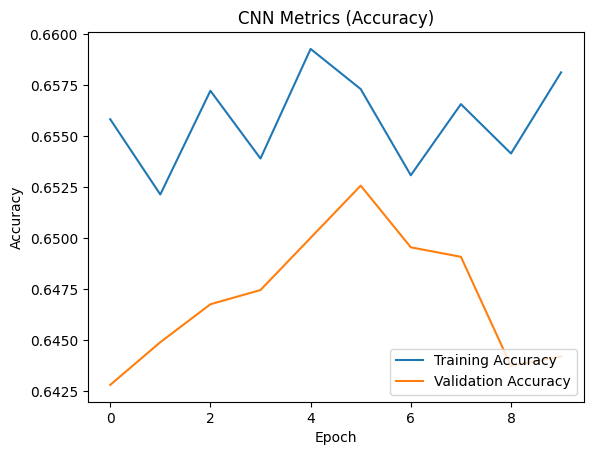

In [16]:
# Plot training and validation accuracy diagram
plt.plot(result.history['accuracy'], label='Training Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

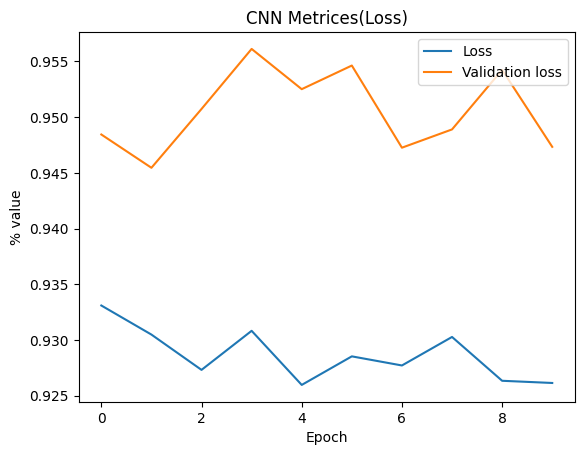

In [17]:
# Plot training and validation loss diagram
plt.plot(result.history['loss'], label='Loss')
plt.plot(result.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [13]:
preds = model.predict_generator(test_data)
y_pred = np.argmax(preds, axis=1)

In [17]:
y_pred_list = y_pred.tolist()
y_pred_list

[0,
 4,
 4,
 0,
 0,
 0,
 0,
 4,
 6,
 0,
 0,
 0,
 0,
 4,
 6,
 4,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 0,
 4,
 0,
 4,
 5,
 0,
 6,
 0,
 0,
 0,
 3,
 4,
 0,
 3,
 0,
 5,
 1,
 2,
 4,
 0,
 0,
 0,
 5,
 0,
 4,
 0,
 4,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 6,
 0,
 0,
 4,
 1,
 3,
 0,
 6,
 0,
 5,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 4,
 0,
 4,
 3,
 0,
 4,
 1,
 0,
 0,
 4,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 0,
 4,
 4,
 0,
 4,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 4,
 5,
 0,
 4,
 0,
 0,
 6,
 0,
 4,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 5,
 0,
 2,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 4,
 6,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 5,
 0,
 0,
 0,
 6,
 0,
 3,
 4,
 2,
 0,
 0,
 2,
 0,
 0,
 5,
 4,
 5,
 5,
 0,
 2,
 0,
 5,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 5,
 0,
 0,
 4,
 0,
 0,
 5,
 0,
 2,
 0,
 4,
 4,
 2,
 0,
 5,
 3,
 0,
 4,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 4,
 0,
 5,
 4,
 4,
 4,
 4,
 0,
 5,
 0,
 5,
 0,
 5,
 0,
 2,
 0,
 0,


In [23]:
def get_label(integer):
    labels_dic = test_data.class_indices
    for label, index in labels_dic.items():
        if index == integer:
            return label
    return None

In [24]:
for i in range(len(y_pred_list)):
    y_pred_list[i]=get_label(y_pred_list[i])

y_pred_list

['angry',
 'neutral',
 'neutral',
 'angry',
 'angry',
 'angry',
 'angry',
 'neutral',
 'surprised',
 'angry',
 'angry',
 'angry',
 'angry',
 'neutral',
 'surprised',
 'neutral',
 'angry',
 'angry',
 'happy',
 'angry',
 'angry',
 'angry',
 'angry',
 'sad',
 'sad',
 'angry',
 'angry',
 'angry',
 'neutral',
 'angry',
 'neutral',
 'sad',
 'angry',
 'surprised',
 'angry',
 'angry',
 'angry',
 'happy',
 'neutral',
 'angry',
 'happy',
 'angry',
 'sad',
 'disgusted',
 'fearful',
 'neutral',
 'angry',
 'angry',
 'angry',
 'sad',
 'angry',
 'neutral',
 'angry',
 'neutral',
 'angry',
 'fearful',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'neutral',
 'angry',
 'surprised',
 'angry',
 'angry',
 'neutral',
 'disgusted',
 'happy',
 'angry',
 'surprised',
 'angry',
 'sad',
 'surprised',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'neutral',
 'angry',
 'angry',
 'neutral',
 'angry',
 'neutral',
 'happy',
 'angry',
 'ne

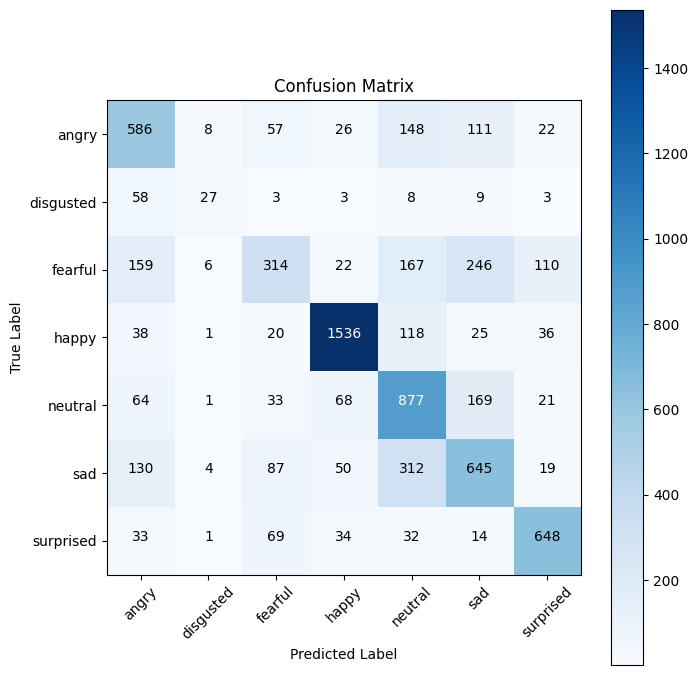

In [19]:
# show confusion_matrix diagram
labels_dic = test_data.class_indices
labels = list(labels_dic.keys())

# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred)

plt.figure(figsize= (7, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation= 45)
plt.yticks(tick_marks, labels)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.show()

In [32]:
def load_image(image_path):

    image = load_img(image_path, target_size=(50, 50), color_mode='grayscale')
    image = img_to_array(image)
    image = image / 255.0  # Rescale to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def get_label(integer, labels_dict):

    for label, index in labels_dict.items():
        if index == integer:
            return label
    return None

def predict_emotion(model, image_path, labels_dict):

    image = load_image(image_path)
    pred = model.predict(image)
    pred = np.argmax(pred)
    label = get_label(pred, labels_dict)
    return label

def show_image_from_path(image_path):
    img = Image.open(image_path)
    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 29ms/step
Predicted emotion: happy


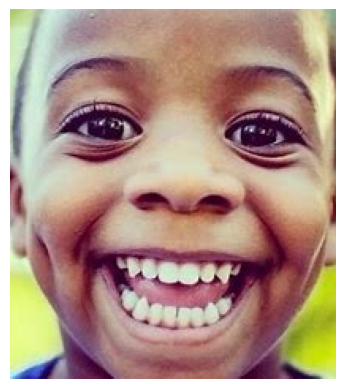

In [33]:
image_file_path = "image 1.jpg"
labels = test_data.class_indices
predicted_emotion = predict_emotion(model, image_file_path, labels)
print(f"Predicted emotion: {predicted_emotion}")
show_image_from_path(image_file_path)

1/1 [==============================] - 0s 32ms/step
Predicted emotion: angry


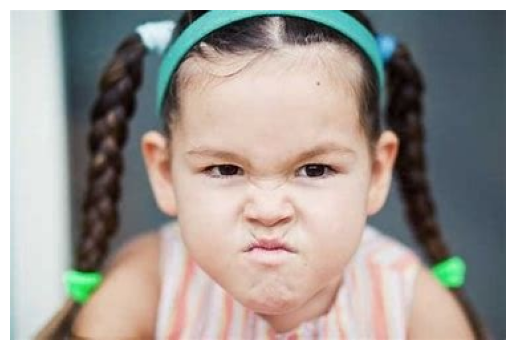

In [34]:
image_file_path = "image 2.jpg"
labels = test_data.class_indices
predicted_emotion = predict_emotion(model, image_file_path, labels)
print(f"Predicted emotion: {predicted_emotion}")
show_image_from_path(image_file_path)